In [1]:
# import sys
# sys.setrecursionlimit(10000)
from time import time
import numpy as np
from Tree.tree_builder import tree_builder
from Tree.tree_values import TreeValues
from Tree.strategy_filling import strategy_filling
from Tree.tree_visualizer import tree_visualizer
from Tree.tree_cfr import TreeCFR
from helper_classes import TreeParams, Node
from Game.card_to_string_conversion import card_to_string
from Game.card_tools import card_tools
from Settings.constants import constants
from Settings.arguments import arguments
from Settings.game_settings import game_settings

In [2]:
PC = constants.players_count
CC = game_settings.card_count

# Tree Build

In [3]:
params = TreeParams()
params.limit_to_street = True
first_node = Node()
first_node.board = np.zeros([], dtype=int)
first_node.street = 1
first_node.current_player = constants.players.P1
first_node.bets = np.array([arguments.ante, arguments.ante], dtype=int)
params.root_node = first_node
params.limit_to_street = True

root = tree_builder.build_tree(params)
strategy_filling.fill_uniform(root)

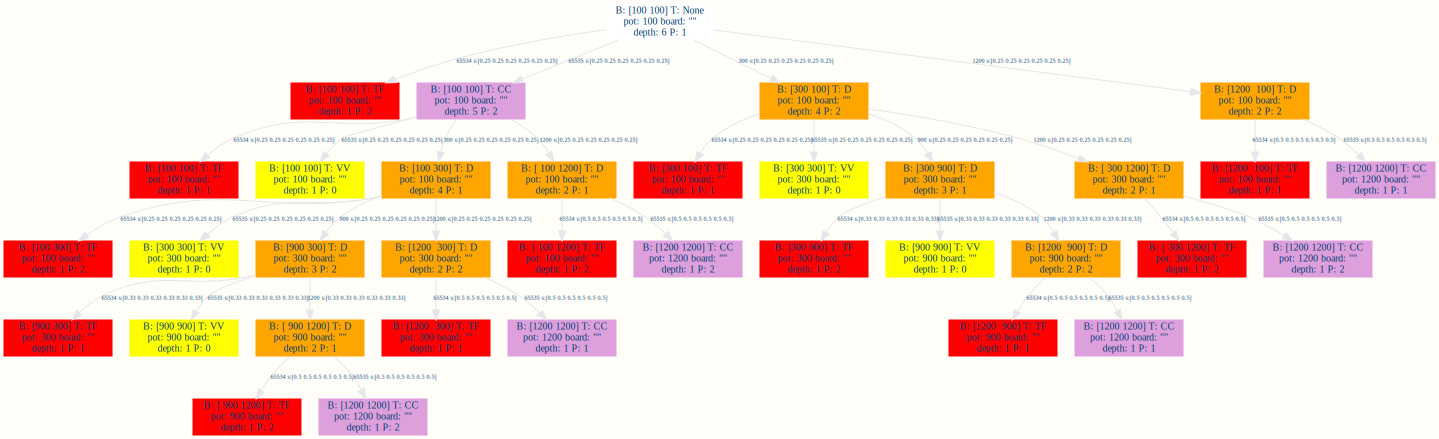

In [4]:
tree_visualizer.draw_tree(root, size='50,30')

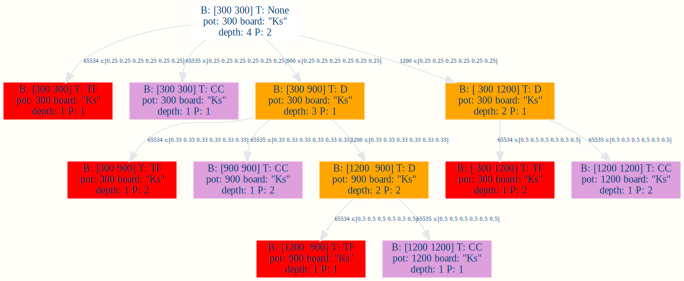

In [5]:
params = TreeParams()
params.root_node = Node()
params.root_node.board = card_to_string.string_to_board('Ks')
params.root_node.street = 2
params.root_node.current_player = constants.players.P2
params.root_node.bets = np.array([300, 300])
params.limit_to_street = False
root = tree_builder.build_tree(params)
tree_visualizer.draw_tree(root, size='20,10')

# Exploitability

In [6]:
params = TreeParams()

params.root_node = Node()
params.root_node.board = card_to_string.string_to_board('')
params.root_node.street = 1
params.root_node.current_player = constants.players.P1
params.root_node.bets = np.array([100, 100])

tree = tree_builder.build_tree(params)

tree_values = TreeValues()

starting_ranges = np.zeros([PC,CC], dtype=arguments.dtype)
starting_ranges[0] = card_tools.get_uniform_range(params.root_node.board)
starting_ranges[1] = card_tools.get_uniform_range(params.root_node.board)

tree_values.compute_values(tree, starting_ranges)

print('Exploitability: ' + str(tree.exploitability) + ' [chips]' )

Exploitability: 175.52084 [chips]


# CFR

Took time: 16.55394411087036 for 600 iters
Exploitability: 2.8279645 [chips]


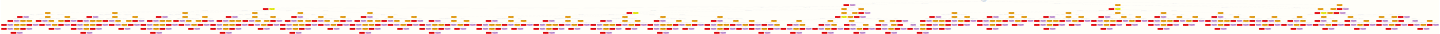

In [4]:
params = TreeParams()

params.root_node = Node()
params.root_node.board = card_to_string.string_to_board('')
params.root_node.street = 1
params.root_node.current_player = constants.players.P1
params.root_node.bets = np.array([100, 100])

tree = tree_builder.build_tree(params)

starting_ranges = np.zeros([PC,CC], dtype=arguments.dtype)
starting_ranges[0] = card_tools.get_uniform_range(params.root_node.board)
starting_ranges[1] = card_tools.get_uniform_range(params.root_node.board)

t0 = time()
tree_cfr = TreeCFR()
tree_cfr.run_cfr(tree, starting_ranges)
print('Took time: {} for {} iters'.format(time()-t0, arguments.cfr_iters))

tree_values = TreeValues()
tree_values.compute_values(tree, starting_ranges)

print('Exploitability: ' + str(tree.exploitability) + ' [chips]' )

In [11]:
import tensorflow.keras as keras
import tensorflow as tf
import numpy as np
from time import time

In [72]:
PC = 2
num_buckets = 1000
num_output = 2000
num_input = num_output + 1

num_layers = 3

In [90]:
m_input = keras.layers.Input([num_input])
m = m_input
# slicing off pot size ([1,2001] -> [1,2000])
sp = keras.layers.Lambda(lambda x: x[ : , 1: ], name='input_ranges')(m_input)
# feed forward part
ff = m_input
for _ in range(num_layers-1):
    ff = keras.layers.Dense(500)(ff)
    ff = keras.layers.PReLU()(ff)
ff = keras.layers.Dense(num_output, name='feed_forward_output')(ff)
# dot product of both (feed forward and player ranges)
d = keras.layers.dot([ff,sp], axes=1)
# repeat this number from shape [1] -> [2000]
d = keras.layers.RepeatVector(num_output)(d)
d = keras.layers.Flatten()(d)
# divide it by 2
d = keras.layers.Lambda(lambda x: x/2)(d)
# subtract input (without pot) and last layer
o = keras.layers.subtract([sp,d], name='zero_sum_output')
m_output = o
model = keras.models.Model(m_input, m_output)
model.summary()
model.predict(np.arange(num_input).reshape(1,num_input))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_57 (InputLayer)           (None, 2001)         0                                            
__________________________________________________________________________________________________
dense_81 (Dense)                (None, 500)          1001000     input_57[0][0]                   
__________________________________________________________________________________________________
p_re_lu_54 (PReLU)              (None, 500)          500         dense_81[0][0]                   
__________________________________________________________________________________________________
dense_82 (Dense)                (None, 500)          250500      p_re_lu_54[0][0]                 
__________________________________________________________________________________________________
p_re_lu_55

array([[-7592596., -7592595., -7592594., ..., -7590599., -7590598.,
        -7590597.]], dtype=float32)

In [29]:
m_input = keras.layers.Input([num_input])
m = m_input

right_part = m

def slice_pot(x):
    return x[ : , 1: ]

right_part = keras.layers.Lambda(slice_tensor)(right_part)

m_output = right_part
model = keras.models.Model(m_input, m_output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 2001)              0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [85]:
t0 = time()
for i in range(100000):
    model.predict(np.arange(num_input).reshape(1,num_input))
print(time()-t0)

68.10844683647156


In [ ]:
suma + daugyma
67.77028489112854
suma + dalyba
68.44798302650452
minus + dalyba


In [10]:
t = np.full([CC,CC], -1, dtype=arguments.int_dtype) # int?
board_idx = 0
for card_1 in range(CC):
    for card_2 in range(card_1+1, CC):
        t[card_1][card_2] = board_idx
        t[card_2][card_1] = board_idx
        board_idx += 1
t

array([[-1,  0,  1,  2,  3,  4],
       [ 0, -1,  5,  6,  7,  8],
       [ 1,  5, -1,  9, 10, 11],
       [ 2,  6,  9, -1, 12, 13],
       [ 3,  7, 10, 12, -1, 14],
       [ 4,  8, 11, 13, 14, -1]], dtype=int16)

In [13]:
CC = 6
board = np.array([0,3])
board_idx = 2
buckets = np.arange(CC)
shift = board_idx * CC
buckets += shift
for i in range(board.shape[0]):
    buckets[ board[i] ] = -1
print(buckets)

[-1 13 14 -1 16 17]


In [17]:
BC = 6
bC = CC * BC
_range_matrix = np.zeros([CC,bC])
class_ids = np.arange(bC)
class_ids = class_ids.reshape([1,bC]) * np.ones([CC,bC])
card_buckets = buckets.reshape([CC,1]) * np.ones([CC,bC], dtype=buckets.dtype)
print(class_ids)
print()
print(card_buckets)

[[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
  18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
  18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
  18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
  18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
  18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
  18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.]]

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -

In [22]:
a = np.array(class_ids == card_buckets, dtype=int)
a

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [23]:
a.T

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [91]:
def gather(a, dim, index):
    return a[ [index if dim==i else np.arange(a.shape[i]).reshape([-1 if i==j else 1 for j in range(a.ndim)]) for i in range(a.ndim)] ]
a = np.arange(1,10).reshape([3,3])
i = np.array([ [0,1,2], [1,2,0] ])
# i = np.array([ [0,1], [1,2], [2,0] ])
g = gather(a, 0, i)
g

array([[1, 5, 9],
       [4, 8, 3]])

In [82]:
def gather(a, dim, index):
    expanded_index = [0] * a.ndim
    temp = [0] * a.ndim
    for i in range(a.ndim):
        if dim==i:
            expanded_index[i] = index
        else:
            for j in range(a.ndim):
                if i == j:
                    temp[j] = -1
                else:
                    temp[j] = 1
            expanded_index[i] = np.arange(a.shape[i]).reshape(temp)
    return a[expanded_index]
            
a = np.arange(1,10).reshape([3,3])
i = np.array([ [0,1,2], [1,2,0] ])
# i = np.array([ [0,1], [1,2], [2,0] ])
g = gather(a, dim, i)
g

array([[1, 5, 9],
       [4, 8, 3]])

In [99]:
def gather(a, dim, index):
    expanded_index = []
    for i in range(a.ndim):
        if dim==i:
            expanded_index.append( index )
        else:
            shape = [-1 if i==j else 1 for j in range(a.ndim)]
            expanded_index.append( np.arange(a.shape[i]).reshape(shape) )
    return a[expanded_index]

In [97]:
def gather(a, dim, index):
    expanded_index = []
    for i in range(a.ndim):
        if dim==i:
            expanded_index.append(index)
        else:
            temp = []
            for j in range(a.ndim):
                if i == j:
                    temp.append(-1)
                else:
                    temp.append(1)
            expanded_index.append( np.arange(a.shape[i]).reshape(temp) )
    return a[expanded_index]

In [100]:
a = np.arange(1,10).reshape([3,3])
i = np.array([ [0,1,2], [1,2,0] ])
# i = np.array([ [0,1], [1,2], [2,0] ])
dim = 0

z = []
for j in range(100):
    t0 = time()
    for _ in range(100000):
        g = gather(a, dim, i)
    t = time()-t0
    z.append(t)
print(np.mean(z), np.std(z))

0.5057456374168396 0.06937347665646587


In [ ]:
big
0.45560665369033815 0.0367693677381111
small
0.5027970004081727 0.05247488669213211
big + np
0.5959889078140259 0.08112115423558021
big + python array
0.4650693345069885 0.03782693625579337
big + temp small
0.45165749073028566 0.02139336214667866